In [187]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from tqdm import tqdm
import pickle
import scipy.fftpack as fft
import swimAD2 as ad2       
import time
import dwfconstants as dwfc
import threading

ad2.disconnect()            
zoroku = ad2.connect(0)
alice = ad2.connect(1)

In [207]:
#하나는 ch1: x,ch2: y 다른 하나는 ch1: x, ch2: z에 꽂을 것 


def sampling(time):
    # Priority on oscilloscope detection rata
    size = 8192
    rate = size/time
    return rate


min_freq = 10
max_freq = 3000
num_freq = 15
rangee = 20
shape = dwfc.funcSine
amp = 0.5
freq = np.linspace(min_freq,max_freq,num_freq)

data = {}
for f in freq:
     data[round(f)] = "NA"

rate = sampling(.10)   

total_results = []

def measure(devices):
    ad2.config_oscilloscope(devices, range0=rangee, range1=rangee, sample_rate=rate)
    result = []
    for f in tqdm(list(data.keys())):
        ad2.config_wavegen(devices, frequency=f, amplitude=amp, signal_shape=shape)
        ad2.start_wavegen(devices, channel=0)
        time.sleep(0.1)
        t0, ch1, ch2 = ad2.measure_oscilloscope(devices)
        ad2.stop_wavegen(devices, channel=0)
        ad2.reset_wavegen(devices, channel=0)
        time.sleep(0.1)
        result.append([f, t0, ch1, ch2])
    total_results.append(result)

def main():
    threads = []
    for devices in [zoroku, alice]:
        thread = threading.Thread(name=str(devices), target=measure, args=(devices,))
        threads.append(thread)
        thread.start()
    for thread in threads:
        thread.join()

main()

100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


In [186]:
for i in range(len(freq)):
    freq = total_results[0][i][0]; t = total_results[0][i][1]
    x,y = total_results[0][i][2], total_results[0][i][3]
    z= (total_results[1][i][3]-y)/100

    fig = plt.figure(figsize=(16, 16))
    grid = gs.GridSpec(6, 6, wspace=0.1)

    plot3D = fig.add_subplot(grid[0:2, 0:2], projection='3d')

    Xf = fft.fft(x)
    Yf = fft.fft(y)
    Zf = fft.fft(z)
    samp = 1e5
    tau = 1/samp # time interval

    fre = fft.fftfreq(len(x), tau)
    axs1 = plt.subplot(grid[0,3:5])
    axs2 = plt.subplot(grid[1,3:5])
    axs3 = plt.subplot(grid[2,3:5])

    axs1.set_xlim(left=0, right=1000, emit=True, auto=False)
    axs2.set_xlim(left=0, right=1000, emit=True, auto=False)
    axs3.set_xlim(left=0, right=1000, emit=True, auto=False)

    axs1.plot(fre[fre>=0], np.abs(Xf)[fre>=0])
    axs2.plot(fre[fre>=0], np.abs(Yf)[fre>=0])
    axs3.plot(fre[fre>=0], np.abs(Zf)[fre>=0])

    time_s = fig.add_subplot(grid[3:5, 0:])

    plot3D.scatter(x, y, z, s=0.3)

    plot3D.set_xlabel("x")
    plot3D.set_ylabel("y")
    plot3D.set_zlabel("z")
    plot3D.set_title("Chua's circuit, freq: " + str(freq))

    [time_s.scatter(t[::10],var[::10]) for var in [x,y,z]]

    time_s.set_title('Time series of chua circuit')
    
    plt.savefig('./result/amp_' + str(amp) + '_freq_' + str(freq) + '.png')
    plt.close("all")

# Syncronisation test

We test with an RC curve whether the above works indeed. 

In [227]:
#하나는 ch1: x,ch2: y 다른 하나는 ch1: x, ch2: z에 꽂을 것 


def sampling(time):
    # Priority on oscilloscope detection rata
    size = 8192
    rate = size/time
    return rate

freqrange = (100,300)
rangee = 20
amp = 2
freq = np.linspace(*freqrange,2)

data = {}
for dev in ["zoroku","alice"]:
    data[dev] = {}
    for f in freq:
        data[dev][f] = "NA"

rate = sampling(.10)   

def measure(device):
    name = "zoroku" if device == zoroku else "alice"
    
    ad2.config_oscilloscope(device, range0=rangee, range1=rangee, sample_rate=rate)
    
    for f in freq:
        ad2.config_wavegen(device, frequency=f, amplitude=amp, signal_shape=dwfc.funcSine)
        ad2.start_wavegen(device, channel=0)
        
        time.sleep(0.1)
        t0, ch1, ch2 = ad2.measure_oscilloscope(device)

        ad2.stop_wavegen(device, channel=0)
        ad2.reset_wavegen(device, channel=0)
        time.sleep(0.1)
        data[name][f] = [t0, ch1, ch2]

def main():
    threads = []
    for devices in [zoroku, alice]:
        thread = threading.Thread(name=devices, target=measure, args=(devices,))
        threads.append(thread)
        thread.start()
    for thread in threads:
        thread.join()

main()

100%|██████████| 1/1 [00:00<00:00, 83.40it/s]


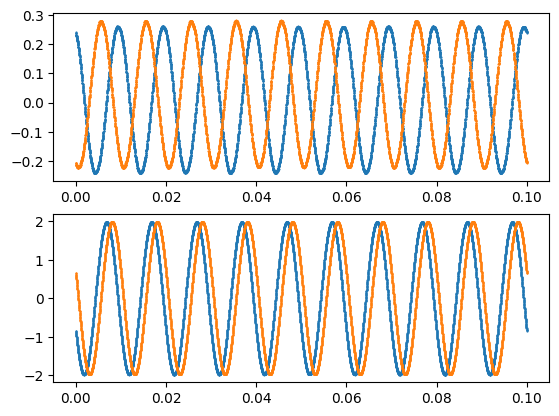

In [228]:
fig,axs = plt.subplots(2,1)
freq = np.linspace(*freqrange,2)

for f in tqdm(freq[0:1]):
    t1,ch1,ch2 = data["alice"][f]
    t2,Ch1,Ch2 = data["zoroku"][f]

    axs[0].scatter(t1,ch1,s=0.3); axs[0].scatter(t2,Ch1,s=0.3)
    axs[1].scatter(t1,ch2,s=0.3); axs[1].scatter(t2,Ch2,s=0.3)

plt.show()
plt.close("all")